# GR 3. - analiza MNIST database

### 0. Wczytanie niezbędnych pakietów i zależności. Zdefiniowanie funkcji pomocniczych.

In [2]:
# pakiety i zależności:

import numpy as np
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics
from sklearn import tree

In [19]:
# funkcje pomocnicze:

def basic_info():
    # liczba obiektów
    print('Liczebność obiektów w danych zbiorach oraz wielkość wczytywanych obrazów w pikselach: ')
    print('\tZbiór uczący: X={}, Y={}'.format(trainX.shape, trainY.shape))
    print('\tZbiór testowy: X={}, Y={}'.format(testX.shape, testY.shape))
    # liczba klas
    classes_train = np.unique(trainY)
    classes_test = np.unique(testY)
    print('\nLiczba klas: ')
    print('\tZbiór uczący: {}'.format(classes_train.shape[0]))
    print('\tZbiór testowy: {}'.format(classes_test.shape[0]))
    # liczba obiektów w każdej klasie
    print('\nLiczba wystąpień każdej z klas (cyfr): ')
    ratio_list = []
    print('\tZbiór uczący\t\tZbiór testowy\t\tStosunek rekordów uczących do testowych')
    for i in range(0, 10):
        training_records_number_of_given_class = len([y for y in trainY if y == classes_train[i]])
        print('\tKlasa \'{}\' -> {}'.format(classes_train[i], training_records_number_of_given_class), end='')
        testing_records_number_of_given_class = len([y for y in testY if y == classes_test[i]])
        print('\tKlasa \'{}\' -> {}'.format(classes_test[i], testing_records_number_of_given_class), end='')
        ratio_list.append(training_records_number_of_given_class / testing_records_number_of_given_class)
        print('\t {}'.format(ratio_list[i]))
    print('\nOdchylenie standardowe stosunków: {}'.format(np.std(ratio_list)))
    print('Średni stosunek: {}'.format(np.mean(ratio_list)))
    print('Współczynnik zmienności: {} %'.format(round(np.std(ratio_list) * 100 / np.mean(ratio_list), 2)))
    # liczba danych brakujących
    print('\nLiczba brakujących danych -> ', end='')
    print(np.isnan(trainX).sum().sum() + np.isnan(trainY).sum() + np.isnan(testX).sum().sum() + np.isnan(trainY).sum().sum())

def display_examples(images, display_width=8, display_height=8, fontsize=36):
    fig, axs = plt.subplots(display_width, display_height)
    fig.set_size_inches(display_width * 2, display_height)
    plt.rc('figure', titlesize=fontsize)
    fig.suptitle('Przedstawienie przykładowych obiektów')
    for y in range(0, display_height):
        for x in range(0, display_width):
            axs[y, x].imshow(images[x + display_width * y], cmap=plt.get_cmap('gray'))
    plt.show()

def display_every_digit_variations(images, display_width=4, display_height=4, fontsize=18):
    for digit_to_find in range(0, 10):
        fig, axs = plt.subplots(display_height, display_width)
        fig.set_size_inches(display_width * 2, display_height)
        plt.rc('figure', titlesize=fontsize)
        fig.suptitle('Przedstawienie przykładowych rekordów z cyfrą {}'.format(digit_to_find))
        current_index = 0
        for y in range(0, display_height):
            for x in range(0, display_width):
                while trainY[current_index] != digit_to_find:
                    current_index += 1        
                axs[y, x].imshow(images[current_index], cmap=plt.get_cmap('gray'))
                current_index += 1    
    plt.show()

def accuracy(model, classifier, display=True):
    model.fit(trainX_flat, trainY)
    cm = confusion_matrix(testY, model.predict(testX_flat))
    if display:
        display_confusion_matrix(cm, classifier)
    return np.sum(np.diag(cm))/np.sum(cm)

def display_confusion_matrix(confusion_matrix_data, classifier):
    plt.figure(figsize=(10,5))
    axs = sns.heatmap(confusion_matrix_data, annot=True, fmt='d', cmap='copper')
    axs.set_title('Macierz pomyłek dla {}'.format(classifier))
    axs.set_xlabel('Przypisane klasy')
    axs.set_ylabel('Wartości rzeczywiste')
    axs.set_xticklabels(range(0, 10))
    axs.set_yticklabels(range(0, 10))

def calculate_error(acc):
    return round((1 - acc) * 100, 2)

### 1. Wprowadzenie i wstępna analiza danych.

Celem projektu jest klasyfikacja cyfr pisanych odręcznie na podstawie bazy MNIST.  
Jest ona zbiorem obrazów przedstawiających właśnie odręcznie pisane cyfry (od 0 do 9), gdzie każda z cyfr wystepuje stosunkowo podobną liczbę razy.  
Obrazy są już po wstępnej obróbce - centryzacji, normalizacji wielkości na 28 x 28 pikseli oraz poddaniu antyaliasingowi (wygładzaniu krawędzi).  
Zbiór danych jest już bazowo podzielony na zbiór uczący oraz treningowy.

Format każdego obiektu: 
- X (obiekty - obrazy) -> dwuwymiarowy numpy array określający jasność poszczególnych pikseli w skali szarości
- Y (atrybuty decyzyjne - przyporządkowanie odpowiedniej cyfry) -> cyfra reprezentowana przez dany rekord

Linki źródłowe:  
- https://en.wikipedia.org/wiki/MNIST_database
- https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/
- https://www.tensorflow.org/datasets/catalog/mnist
- https://towardsdatascience.com/image-classification-in-10-minutes-with-mnist-dataset-54c35b77a38d

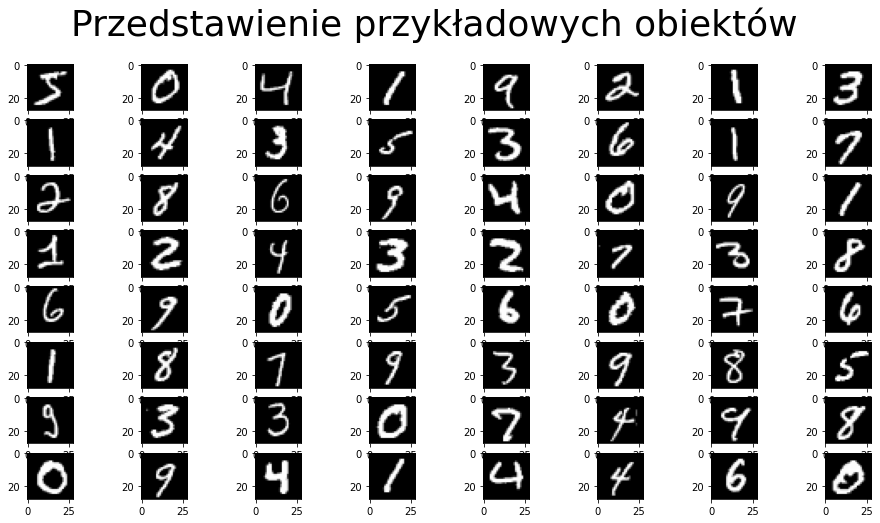

Liczebność obiektów w danych zbiorach oraz wielkość wczytywanych obrazów w pikselach: 
	Zbiór uczący: X=(60000, 28, 28), Y=(60000,)
	Zbiór testowy: X=(10000, 28, 28), Y=(10000,)

Liczba klas: 
	Zbiór uczący: 10
	Zbiór testowy: 10

Liczba wystąpień każdej z klas (cyfr): 
	Zbiór uczący		Zbiór testowy		Stosunek rekordów uczących do testowych
	Klasa '0' -> 5923	Klasa '0' -> 980	 6.043877551020408
	Klasa '1' -> 6742	Klasa '1' -> 1135	 5.940088105726872
	Klasa '2' -> 5958	Klasa '2' -> 1032	 5.773255813953488
	Klasa '3' -> 6131	Klasa '3' -> 1010	 6.07029702970297
	Klasa '4' -> 5842	Klasa '4' -> 982	 5.94908350305499
	Klasa '5' -> 5421	Klasa '5' -> 892	 6.077354260089686
	Klasa '6' -> 5918	Klasa '6' -> 958	 6.177453027139875
	Klasa '7' -> 6265	Klasa '7' -> 1028	 6.094357976653696
	Klasa '8' -> 5851	Klasa '8' -> 974	 6.007186858316222
	Klasa '9' -> 5949	Klasa '9' -> 1009	 5.89593657086224

Odchylenie standardowe stosunków: 0.11028863479351828
Średni stosunek: 6.002889069652045
Współczynnik zmie

In [4]:
# wczytanie bazy danych MNIST
(trainX, trainY), (testX, testY) = mnist.load_data()

# wyświetlenie kilku pierwszych rekordów
display_examples(trainX)

# podstawowe własności zbioru danych
basic_info()

Analizując podstawowe własności zauważamy kompletność i spójność danych - nie wykryto nieprawidłowo zapisanych danych; liczbie obiektów zarówno przy zbiorze uczącym jak i testowym odpowiada tożsama im liczba atrybutów decyzyjnych; klas w obu zbiorach jest tyle samo i odpowiadają sobie nawzajem.  
Obserwujemy też stosunkowo zbliżoną liczbę obiektów przyporządkowaną do poszczególnych klas (choć zdecydowanie nie równą - skrajna różnica (dla 1 oraz 5) wynosi aż 1321).  
Co ciekawe, zbiór testowy nie jest podzielony dokładnie w takich samych proporcjach jak uczący (choć podział ten jest zbliżony) - współczynnik zmienności stosunków liczby rekordów uczących do testowych dla poszczególnych klas nie jest zerowy - wynosi 1.84 %. Nie jest to jednak wartość znacząco różnicująca udział poszczególnych klas w zbiorze uczącym i testowym - proporcje te są zbliżone.  
Do tworzenia modeli wykorzystamy zatem cały zbiór uczący, bez podziałów na podzbiory. Zakładamy bowiem prawidłowy, spójny i stosunkowo regularny podział zbiorów zawartych w bazie  MNIST.

In [ ]:
# wizualizacja powtarzalności / zróżnicowania rekordów tych samych klas
display_every_digit_variations(trainX, 6, 3)

Obserwujemy znaczące zróżnicowanie obiektów na przestrzeni jednej klasy. Dla przykładu cyfra 1 przez niektórych zpisywana jest jako podłużna "pałeczka" (w dodatku o różnych orientacjach), inni natomiast akcentują jej "głowę" oraz "podstawę". Podobnie 7 - w większości rekordów napisana jest za pomocą pojedynczej łamanej, jednak czasem, choć nieczęsto, zawiera też "przekreślenie". Stosunkowa nieliczność tego przypadku mogłaby skutkować na przykład w klasyfikowaniu tak napisanej cyfry 7 jako 4, która w przeważającej większości "przekreślenie" wyraźnie zawiera. Różnice obejmują także "domykanie" cyfr - czasem pętla, która powinna być zamknięta, tworząc "dziurę", pozostaje otwarta, pozostawiając cyfrę bez wyraźnej, właściwej jej dziury (0, 6, 8, 9). Widocznych jest także wiele innych subtylnych różnic. Czasem nawet cyfry zapisane są niemal nieczytelnie nawet dla czytającego je człowieka - niech przykładem będzie jedna z cyfr 2, będąca jedynie nieco dziwną pętelką. Analizowane cyfry odręczne różnią się więc w znaczącym stopniu od ustandaryzowanego pisma komputerowego, z którego w sposób bardziej określony można by wywnioskować pewne cechy opisujące.  

Wynika stąd, że niezwykle trudno byłoby określić i właściwie dopasować cechy obiektów, które mogłyby posłużyć do klasyfikacji. Orientacja potrafi być zróżnicowana na przestrzeni jednej klasy, podobnie liczba Eulera. Niektóre obiekty są bardziej rozwlekłe, inne bardziej skondensowane. Występują nawet zdecydowanie różne sposoby pisania tej samej cyfry.  

Biorąc powyższe pod uwagę, jako atrybutów opisujących użyjemy każdego piksela oddzielnie. Zatem będzie ich 28 * 28 = 784. Każdy z nich zaś określa jasność danego piksela w skali szarości <0, 255>.  

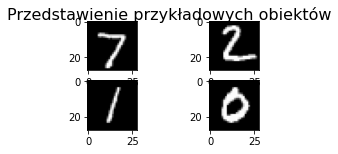

[7 2 1 ... 4 5 6]


In [5]:
# "spłaszczenie" macierzy pikseli każdego z obrazów do jednowymiarowych wektorów atrybutów opisowych
trainX_flat = trainX.flatten().reshape(60000, 784)
testX_flat  = testX.flatten().reshape(10000, 784)

# upewnimy się jeszcze pobieżnie, czy dane zostały spłaszczone prawidłowo:
# pierwsze obiekty testowe
display_examples(testX, 2, 2, 16)
# skorzystamy w tym celu z przykładowego klasyfikatora - najbliższego sąsiada
model = KNeighborsClassifier(n_neighbors = 1)
model.fit(trainX_flat, trainY)
print(model.predict(testX_flat))

Jak widać powyżej, pierwsze trzy cyfry klasyfikowane są prawidłowo. Zakładamy zatem, że spłaszczanie przebiegło prawidłowo.

### 2. Klasyfikatory z zajęć - wybór najlepszego:

Pod uwagę weźmiemy następujące klasyfikatory:  
a) Metoda k-najbliższych sąsiadów (w różnych wariantach)  
b) Metoda najbliższego prototypu  
c) Naiwny klasyfikatory Bayesa  
d) Drzewa decyzyjne (w różnych wariantach)

UWAGA! Wszelkie wnioski prowadzone są przy założeniu przyjęcia za atrybuty opisujące każdego piksela z osobna. Prawdopodobnym jest, że przy innym ich doborze wnioski znacząco by się różniły.  
Warte wspomnienia również jest, że przy klasyfikatorach minimalnoodległościowych badaliśmy jedynie przypadek wykorzystania metryki euklidesowej (miejska oraz Czybyszewa miały nieporównywalnie dłuższy czas obliczeń).

#### a) Klasyfikator k-najbliższych sąsiadów

	k =  1  	Dokładność = 0.9691	 Błąd = 3.09 %
	k =  3  	Dokładność = 0.9705	 Błąd = 2.95 %
	k =  5  	Dokładność = 0.9688	 Błąd = 3.12 %
	k =  7  	Dokładność = 0.9694	 Błąd = 3.06 %
	k =  9  	Dokładność = 0.9659	 Błąd = 3.41 %
	k = 11  	Dokładność = 0.9668	 Błąd = 3.32 %
	k = 13  	Dokładność = 0.9653	 Błąd = 3.47 %
	k = 15  	Dokładność = 0.9633	 Błąd = 3.67 %


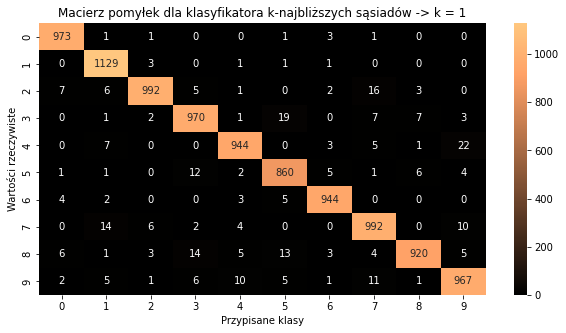

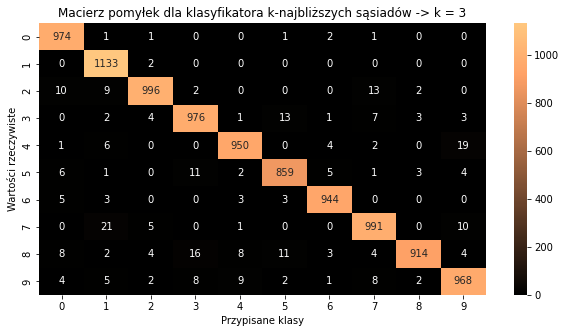

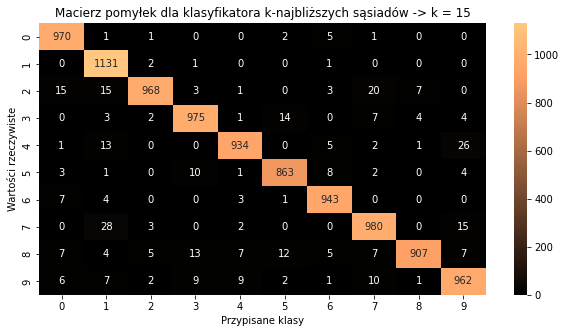

In [27]:
for k in range(1, 16, 2):
    model = KNeighborsClassifier(n_neighbors = k)
    acc = accuracy(model, 'klasyfikatora k-najbliższych sąsiadów -> k = {}'.format(k), k in [1, 3, 15])
    print('\tk = {:2d}  \tDokładność = {}\t Błąd = {} %'.format(k, acc, calculate_error(acc)))

Dokładność klasyfikatora k-najbliższych sąsiadów dla każdej wartości k okazała się być znacząca. W najlepszym przypadku (dla k = 3) błędne dopasowania stanowią jedynie 2.95%, w najgorszym zaś (dla k = 15) stosunkowo niedużo więcej, bo 3.67 %.  
Jako że wskazany klasyfikator nie przechodzi fazy uczenia, czas oczekiwania na wyniki był stosunkowo długi (w porównaniu do pozostałych klasyfikatorów), jednak jest to rekompensowanane dużą dokładnością.  
Na macierzach pomyłek obserwujemy, rekordy których klas zostały niewłaściwie przypisane. Pomimo innych liczebności, dla różnych k tendencje są raczej podobne. Pojedyncze przyprzypadki okazjonalnie się zdarzają, niewykluczone jest bowiem istnienie w danych zbiorach wartości nieczytelnych tak dla komputera jak i dla człowieka (przykładowo jedna z dwójek obserwowanych na początku). Według modelu największym podobieństwem odznaczały się: 2 -> 0, 1, 7; 3 -> 5; 4 -> 9, 5 -> 3; 7 -> 1, 9; 8 -> 3, 5. Co ciekawe, jedyną parą dwustronnie do siebie podobną są cyfry 5 i 3. Najbardziej niepodobne do innych okazały się 0 i 1, później 6. Można zatem z powodzeniem sprawdzać pisemne prace zaliczeniowe z techniki cyfrowej za pomocą przedstawionego modelu (choć sam model to chyba jednak wciąż trochę zbyt mało).

#### b) Klasyfikator najbliższego prototypu

Dokładność = 0.8203	 Błąd = 17.97 %


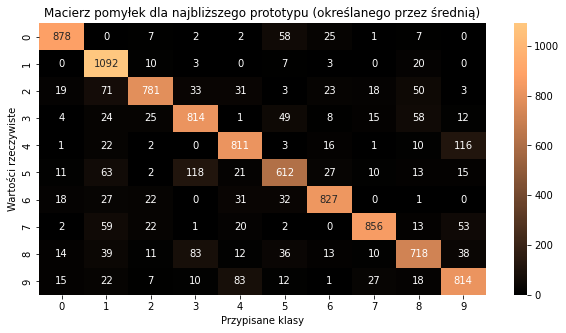

In [28]:
model = NearestCentroid()
acc = accuracy(model, 'najbliższego prototypu (określanego przez średnią)')
print('Dokładność = {}\t Błąd = {} %'.format(acc, calculate_error(acc)))

Klasyfikator najbliższego prototypu okazał się naturalnie nieporównywalnie szybszy niż k-najbliższych sąsiadów - przez wzgląd na proces uczenia.
Jednak wyniki klasyfikacji są znacząco mniej dokładne - błąd jest na poziomie prawie 18%. Jest to wynik na ogół niedopuszczalny, jednak wciąż imponujący jest taki poziom dokładności przy tej szybkości działania. Również z natury sama metoda uśrednienia każdego rekordu danej klasy do jednej ustalonej wartości źle służyć może generalizacji przypadków nieco bardziej odchylonych od normy - możliwe że mniejsza liczba danych uczących poprawiłaby wynik tego klasyfikatora.  
Z macierzy pomyłek wyczytujemy, że najlepiej dopasowano cyfrę 1. Przypadki złych przypisań natomiast są tu dużo częstsze niż poprzednio. 5 zostało określone jako 3 oraz 4 jako 9 więcej niż stukrotnie! Ponownie, raczej niewiele jest par cyfr mylonych w dużym stopniu naprzemiennie. Są to 2 i 8, 5 i 3, 0 i 6.

#### c) Naiwny klasyfikator Bayesa

Dokładność = 0.5558	 Błąd = 44.42 %


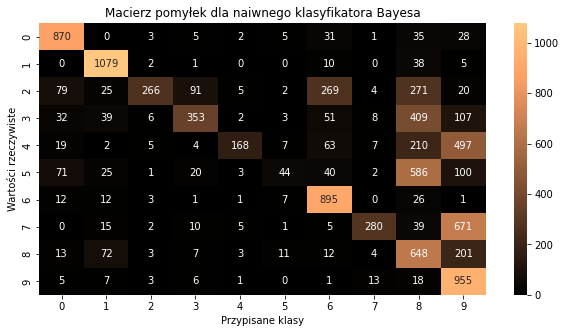

In [29]:
model = GaussianNB()
acc = accuracy(model, 'naiwnego klasyfikatora Bayesa')
print('Dokładność = {}\t Błąd = {} %'.format(acc, calculate_error(acc)))

Naiwny klasyfikator Bayesa odznaczył się dokładnością zaledwie około 55.6 %. Do przedstawionego zadania raczej się więc nie nadaje, jednak wciąż daje lepsze wyniki niż rzut kostką dziesięciościenną. Słabość utworzonego modelu spowodowana jest najpewniej tytułową "naiwnością" klasyfikatora. Oznacza ona, że z założenia atrybuty opisujące powinny być od siebie w znacznym stopniu niezależne. Jednak przy analizie obrazu założenie to jest prawie na pewno niespełniane - jeżeli któryś punkt jest bowiem jasny (zamalowany), to wtedy prawdopodobnym jest, że punkt sąsiedni też taki będzie. Również przy określaniu wzorca (klasyfikacji) naszym celem jest poszukiwanie takich właśnie zależności. Biorąc to pod uwagę, możliwe że model poradził sobie tutaj nawet lepiej niż powinien.  
Przeważająca liczba złych przypisań to wskazywanie na 8 lub 9. Co ciekawe, cyfry 1 i 9 zostały niewłaściwie przypisane w stosunkowo niewielu przypadkach, podobnie cyfra 6, a następnie 0. Podobną tendencją niepodobieństwa wykazał się klasyfikator k-najbliższych sąsiadów. Jednak cyfry 2, 3, 4, 5 i 7 już tyle szczęścia nie miały - częściej były klasyfikowane jako coś innego niż one same.  
Założenie wyższości tego modelu nad kostką należy więc zmodyfikować - rozpoznaje on bowiem jedynie niektóre cyfry, pozostałe niemal definitywnie przypisując w niewłaściwy sposób.

#### d) Drzewa decyzyjne

	max_depth =  1  	Dokładność = 0.1994	 Błąd = 80.06 %
	max_depth =  3  	Dokładność = 0.4953	 Błąd = 50.47 %
	max_depth =  5  	Dokładność = 0.6747	 Błąd = 32.53 %
	max_depth =  7  	Dokładność = 0.7853	 Błąd = 21.47 %
	max_depth =  9  	Dokładność = 0.8501	 Błąd = 14.99 %
	max_depth = 11  	Dokładność = 0.876	 Błąd = 12.4 %
	max_depth = 13  	Dokładność = 0.8787	 Błąd = 12.13 %
	max_depth = 15  	Dokładność = 0.8823	 Błąd = 11.77 %
	max_depth = 17  	Dokładność = 0.8832	 Błąd = 11.68 %
	max_depth = 19  	Dokładność = 0.8801	 Błąd = 11.99 %
	max_depth = 21  	Dokładność = 0.8782	 Błąd = 12.18 %
	max_depth = 23  	Dokładność = 0.8769	 Błąd = 12.31 %
	max_depth = 25  	Dokładność = 0.8793	 Błąd = 12.07 %
	max_depth = 27  	Dokładność = 0.8764	 Błąd = 12.36 %
	max_depth = 29  	Dokładność = 0.8804	 Błąd = 11.96 %


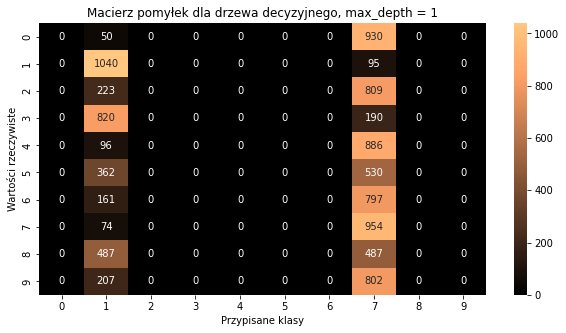

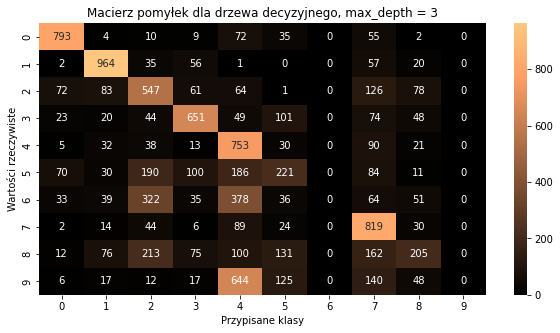

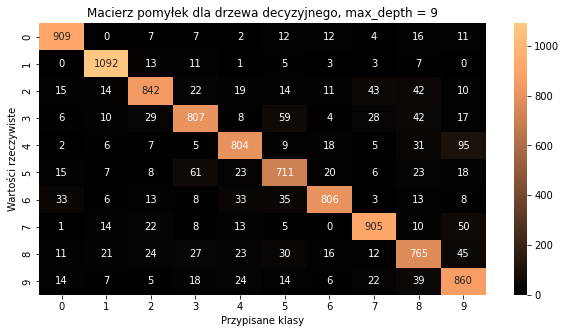

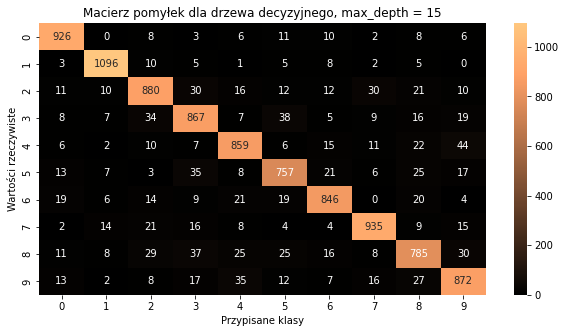

In [40]:
for depth in range(1, 31, 2):
    model = tree.DecisionTreeClassifier(max_depth=depth)
    acc = accuracy(model, 'drzewa decyzyjnego, max_depth = {}'.format(depth), depth in [1, 3, 9, 15])
    print('\tmax_depth = {:2d}  \tDokładność = {}\t Błąd = {} %'.format(depth, acc, calculate_error(acc)))

Przy pojedynczej decyzji, właściwy wynik osiągamy w około 20% przypadków - to wynik bardzo analogiczny do rzutu dziesięciościenną kostką! Choć może jednak niekoniecznie, bo macierz pomyłek wyraźnie wskazuje, że model nauczył się jedynie w miarę sprawnie wskazywać 1 oraz 7 (jeżeli dostanie je na wejściu). Jednak w pozostałych przypadkach też wskaże te cyfry, innych zaś nigdy! Jednak oczywiście przy szerszym zakresie decyzyjnym dokładność modelu rośnie, osiągając szczytową wartość około 88.32 % przy maksymalnej głębokości wynoszącej 17 (możliwe że udałoby się znaleźć inną, jeżeli sprawdzalibyśmy też parzyste głębokości, jednak różnica byłaby definitywnie nieznaczna). W ogólności, przy głębokości większej / równej 11 dokładność kolejnych iteracji się stabilizuje, oscylując pomiędzy 87.5 % a 88.5 %. Dostrzec można jednak pewną, wspomnianą wcześniej wartość maksymalną. Dla kolejnych iteracji względem niej obserwwujemy delikatną utratę jakości modelów, prawdopodobnie przez zjawisko przeuczenia i utraty zdolności generalizacyjnych. Co ciekawe, zjawisko to nie postępuje stopniowo / monotonicznie, zaskakując czasem wynikami klasyfikacji lepszymi od poprzednich. Również warte wspomnienia jest, że kolejne uruchomienia programu generowały nieco inne wyniki.  
Obserwujemy na macierzy pomyłek zadziwiające w stosunku do pozostałych klasyfikatorów zjawisko - gdzie odpowiadające sobie przypisania podobnych cyfr były rzadkością, tutaj są niezwykle powszechne. Wynika to najprawdopodobniej ze struktury drzewa decyzyjnego. Po wejściu w ostatni węzeł przed wybraniem jednego z dwóch liści, obiekt zostanie sklasyfikowany bowiem jako jeden albo drugi, a nie żaden inny.

### 3. Preprocessing obrazów dla najlepszego klasyfikatora

- metoda rozmywania
- zmniejszenie rozdzielczości

### 4. Ponowna weryfikacja klasyfikatorów dla najbardziej obiecujących preprocessingów

### 5. Próba użycia sieci neuronowych.

- sieć splotowa, warstwy splotowe, redukcyjne i spłaszczanie

### 6. Porównanie rozwiązań i wnioski.

### 7. Próba sklasyfikowania małego zbioru cyfr napisanych przez nas odręcznie